In [1]:
!pip install torch_geometric

In [2]:
import torch
print(torch.__version__)


2.6.0+cu124


In [4]:
import torch
from torch_geometric.data import Data
import json
from glob import glob
import os
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api

# Download NLTK resources
nltk.download('stopwords', quiet=True)

# Load GloVe
word_vectors = api.load('glove-wiki-gigaword-300')

# Load CSVs
id_service = pd.read_csv('/kaggle/input/graphdata/graph_data/raw/id_service.csv', index_col=0)
id_url_type = pd.read_csv('/kaggle/input/graphdata/graph_data/raw/id_url+type.csv', index_col=0)

# Preprocess event templates
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
    words = text.split()
    return ' '.join(word for word in words if word not in stop_words)

# Prepare event templates
event_templates = id_url_type[['Temp', 'Type', 'Content']].drop_duplicates()
event_templates['ProcessedText'] = event_templates['Content'].apply(preprocess_text)
log_events = event_templates[event_templates['Type'] == 4]['ProcessedText'].tolist()
span_events = event_templates[event_templates['Type'].isin([0, 1, 2, 3, 5, 6, 7])]['ProcessedText'].tolist()

# Compute TF-IDF and save embeddings
embedding_file = '/kaggle/working/event_embeddings.npy'
if not os.path.exists(embedding_file):
    tfidf_vectorizer_log = TfidfVectorizer()
    tfidf_vectorizer_span = TfidfVectorizer()
    tfidf_matrix_log = tfidf_vectorizer_log.fit_transform(log_events)
    tfidf_matrix_span = tfidf_vectorizer_span.fit_transform(span_events)
    
    def word_embedding(word):
        try:
            return word_vectors.get_vector(word).astype(np.float32)
        except KeyError:
            return np.zeros(300, dtype=np.float32)
    
    def get_weighted_sentence_embedding(text, tfidf_vectorizer, tfidf_matrix, row_index):
        words = text.split()
        embedding = np.zeros(300, dtype=np.float32)
        count = 0
        for word in words:
            if word in tfidf_vectorizer.vocabulary_:
                tfidf_score = tfidf_matrix[row_index, tfidf_vectorizer.vocabulary_[word]]
                embedding += tfidf_score * word_embedding(word)
                count += 1
        return embedding / (count or 1)
    
    event_embeddings = {}
    for idx, row in event_templates.iterrows():
        temp_id, event_type, text = row['Temp'], row['Type'], row['ProcessedText']
        row_idx = idx if event_type == 4 else idx - len(log_events)
        tfidf_vectorizer = tfidf_vectorizer_log if event_type == 4 else tfidf_vectorizer_span
        tfidf_matrix = tfidf_matrix_log if event_type == 4 else tfidf_matrix_span
        event_embeddings[temp_id] = get_weighted_sentence_embedding(text, tfidf_vectorizer, tfidf_matrix, row_idx)
    
    np.save(embedding_file, event_embeddings)
    del word_vectors, tfidf_matrix_log, tfidf_matrix_span  # Free memory
else:
    event_embeddings = np.load(embedding_file, allow_pickle=True).item()

def process_json_data(data, scaler):
    edge_index = torch.tensor(data['edge_index'], dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(data['edge_attr'], dtype=torch.long)
    node_features = np.array(data['node_info'], dtype=np.float32)
    
    # Map node IDs to event embeddings
    node_ids = node_features[:, 0].astype(int)
    event_embs = np.array([event_embeddings.get(id_, np.zeros(300, dtype=np.float32)) for id_ in node_ids], dtype=np.float32)
    
    # Normalize numerical features
    numerical_features = node_features[:, 1:]  # 6 features
    numerical_features = scaler.transform(numerical_features) if numerical_features.size > 0 else np.zeros((len(node_ids), 0), dtype=np.float32)
    
    # Combine features
    node_features = np.hstack([numerical_features, event_embs]).astype(np.float32)
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    label = 0 if data['error_trace_type'] == 'normal' else 1
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)

def collect_numerical_features(json_files, max_samples=10000):
    scaler = StandardScaler()
    batch_size = 1000
    numerical_features = []
    sample_count = 0
    
    for f in json_files:
        with open(f, 'r') as file:
            for line in file:
                if sample_count >= max_samples:
                    break
                line = line.strip()
                if not line:
                    continue
                try:
                    data = json.loads(line)
                    node_features = np.array(data['node_info'], dtype=np.float32)[:, 1:]
                    numerical_features.append(node_features)
                    sample_count += 1
                    if len(numerical_features) >= batch_size:
                        batch = np.vstack(numerical_features)
                        scaler.partial_fit(batch)
                        numerical_features = []
                except json.JSONDecodeError:
                    continue
        if sample_count >= max_samples:
            break
    
    if numerical_features:
        batch = np.vstack(numerical_features)
        scaler.partial_fit(batch)
    
    return scaler

def load_graph_from_json(json_path, scaler, device):
    graphs = []
    try:
        with open(json_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    data = json.loads(line)
                    num_nodes = len(data['node_info'])
                    if data['edge_index']:
                        max_index = max(max(pair) for pair in data['edge_index'])
                        if max_index >= num_nodes:
                            print(f"Invalid edge_index in {json_path}: max index {max_index}, num_nodes {num_nodes}")
                            continue
                    graph = process_json_data(data, scaler).to(device)
                    graphs.append(graph)
                except json.JSONDecodeError as e:
                    print(f"Error parsing object in {json_path}: {e}")
                    continue
    except Exception as e:
        print(f"Error reading {json_path}: {e}")
    return graphs

# Load only first two JSON files
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
directory = '/kaggle/input/graphdata/graph_data/raw'
json_files = [f for f in glob(f'{directory}/*.jsons') if 'process0.jsons' in f or 'process1.jsons' in f or 'process3.jsons' in f]
scaler = collect_numerical_features(json_files, max_samples=10000)

dataset = []
for f in json_files:
    graphs = load_graph_from_json(f, scaler, device)
    print(f"Loaded {len(graphs)} graphs from {f}")
    dataset.extend(graphs)

normal_dataset = [g for g in dataset if g.y.item() == 0]
print(f"Loaded {len(dataset)} graphs, {len(normal_dataset)} normal graphs")

# Debug batching
from torch_geometric.loader import DataLoader
train_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)
for i, data in enumerate(train_loader):
    print(f"Batch {i}: num_nodes={data.num_nodes}, num_edges={data.num_edges}, batch_size={data.batch.max().item() + 1}")
    print(f"Batch tensor shape: {data.batch.shape}, max node index: {data.edge_index.max().item()}")
    if i > 2:
        break

Loaded 16561 graphs from /kaggle/input/graphdata/graph_data/raw/process1.jsons
Loaded 16561 graphs from /kaggle/input/graphdata/graph_data/raw/process3.jsons
Loaded 16559 graphs from /kaggle/input/graphdata/graph_data/raw/process0.jsons
Loaded 49681 graphs, 40870 normal graphs
Batch 0: num_nodes=6559, num_edges=7211, batch_size=32
Batch tensor shape: torch.Size([6559]), max node index: 6558
Batch 1: num_nodes=5839, num_edges=6420, batch_size=32
Batch tensor shape: torch.Size([5839]), max node index: 5838
Batch 2: num_nodes=6558, num_edges=7093, batch_size=32
Batch tensor shape: torch.Size([6558]), max node index: 6557
Batch 3: num_nodes=6901, num_edges=7376, batch_size=32
Batch tensor shape: torch.Size([6901]), max node index: 6900


In [5]:
# Debug missing embeddings
unique_node_ids = set()
for graph in dataset:
    node_ids = graph.x[:, 0].cpu().numpy().astype(int)  # First column is node ID
    unique_node_ids.update(node_ids)

all_templates = set(id_url_type['Temp'].unique())
missing_embeddings = all_templates - set(event_embeddings.keys())
used_node_ids = unique_node_ids - set(event_embeddings.keys())

print(f"Total unique templates in id_url_type: {len(all_templates)}")
print(f"Embeddings available: {len(event_embeddings)}")
print(f"Missing embeddings (not in event_embeddings): {len(missing_embeddings)}")
print(f"Node IDs used in graphs but missing embeddings: {len(used_node_ids)}")
if missing_embeddings:
    print("Missing template IDs:", sorted(list(missing_embeddings)))
if used_node_ids:
    print("Node IDs with missing embeddings:", sorted(list(used_node_ids)))

Total unique templates in id_url_type: 1513
Embeddings available: 1513
Missing embeddings (not in event_embeddings): 0
Node IDs used in graphs but missing embeddings: 0


In [ ]:
# import torch
# from torch_geometric.data import Data
# import json
# from glob import glob
# import os
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# # Load embeddings
# embedding_file = '/kaggle/input/embeddings/event_embeddings.npy'
# if not os.path.exists(embedding_file):
#     raise FileNotFoundError(f"Embedding file {embedding_file} not found. Please rerun the full preprocessing script.")
# event_embeddings = np.load(embedding_file, allow_pickle=True).item()
# print(f"Loaded {len(event_embeddings)} event embeddings from {embedding_file}")

# # Load CSVs
# id_service = pd.read_csv('/kaggle/input/graphdata/graph_data/raw/id_service.csv', index_col=0)
# id_url_type = pd.read_csv('/kaggle/input/graphdata/graph_data/raw/id_url+type.csv', index_col=0)

# def process_json_data(data, scaler):
#     edge_index = torch.tensor(data['edge_index'], dtype=torch.long).t().contiguous()
#     edge_attr = torch.tensor(data['edge_attr'], dtype=torch.long)
#     node_features = np.array(data['node_info'], dtype=np.float32)
    
#     # Map node IDs to event embeddings
#     node_ids = node_features[:, 0].astype(int)
#     event_embs = np.array([event_embeddings.get(id_, np.zeros(300, dtype=np.float32)) for id_ in node_ids], dtype=np.float32)
    
#     # Normalize numerical features
#     numerical_features = node_features[:, 1:]  # 6 features
#     numerical_features = scaler.transform(numerical_features) if numerical_features.size > 0 else np.zeros((len(node_ids), 0), dtype=np.float32)
    
#     # Combine features
#     node_features = np.hstack([numerical_features, event_embs]).astype(np.float32)
#     node_features = torch.tensor(node_features, dtype=torch.float)
    
#     label = 0 if data['error_trace_type'] == 'normal' else 1
#     y = torch.tensor([label], dtype=torch.long)
#     return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)

# def collect_numerical_features(json_files, max_samples=10000):
#     scaler = StandardScaler()
#     batch_size = 1000
#     numerical_features = []
#     sample_count = 0
    
#     for f in json_files:
#         with open(f, 'r') as file:
#             for line in file:
#                 if sample_count >= max_samples:
#                     break
#                 line = line.strip()
#                 if not line:
#                     continue
#                 try:
#                     data = json.loads(line)
#                     node_features = np.array(data['node_info'], dtype=np.float32)[:, 1:]
#                     numerical_features.append(node_features)
#                     sample_count += 1
#                     if len(numerical_features) >= batch_size:
#                         batch = np.vstack(numerical_features)
#                         scaler.partial_fit(batch)
#                         numerical_features = []
#                 except json.JSONDecodeError:
#                     continue
#         if sample_count >= max_samples:
#             break
    
#     if numerical_features:
#         batch = np.vstack(numerical_features)
#         scaler.partial_fit(batch)
    
#     return scaler

# def load_graph_from_json(json_path, scaler):
#     graphs = []
#     try:
#         with open(json_path, 'r') as f:
#             for line in f:
#                 line = line.strip()
#                 if not line:
#                     continue
#                 try:
#                     data = json.loads(line)
#                     num_nodes = len(data['node_info'])
#                     if data['edge_index']:
#                         max_index = max(max(pair) for pair in data['edge_index'])
#                         if max_index >= num_nodes:
#                             print(f"Invalid edge_index in {json_path}: max index {max_index}, num_nodes {num_nodes}")
#                             continue
#                     graph = process_json_data(data, scaler)
#                     graphs.append(graph)
#                 except json.JSONDecodeError as e:
#                     print(f"Error parsing object in {json_path}: {e}")
#                     continue
#     except Exception as e:
#         print(f"Error reading {json_path}: {e}")
#     return graphs

# # Load only first two JSON files
# directory = '/kaggle/input/graphdata/graph_data/raw'
# json_files = [f for f in glob(f'{directory}/*.jsons') if 'process0.jsons' in f or 'process1.jsons' in f]
# scaler = collect_numerical_features(json_files, max_samples=10000)

# dataset = []
# for f in json_files:
#     graphs = load_graph_from_json(f, scaler)
#     print(f"Loaded {len(graphs)} graphs from {f}")
#     dataset.extend(graphs)

# normal_dataset = [g for g in dataset if g.y.item() == 0]
# print(f"Loaded {len(dataset)} graphs, {len(normal_dataset)} normal graphs")

# # Debug batching
# from torch_geometric.loader import DataLoader
# train_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)
# for i, data in enumerate(train_loader):
#     print(f"Batch {i}: num_nodes={data.num_nodes}, num_edges={data.num_edges}, batch_size={data.batch.max().item() + 1}")
#     print(f"Batch tensor shape: {data.batch.shape}, max node index: {data.edge_index.max().item()}")
#     if i > 2:
#         break

In [6]:
sample_graph = dataset[0]
print(f"Sample graph node features shape: {sample_graph.x.shape}")  # Should be [num_nodes, 306]
print(f"First node features: {sample_graph.x[0]}")  # 306D vector

Sample graph node features shape: torch.Size([902, 306])
First node features: tensor([ 8.9902e-01, -1.0181e+00, -2.5099e-02, -1.8792e+00, -1.2292e+00,
         1.0259e+00, -5.0814e-02, -5.2755e-03,  2.8241e-04,  7.1702e-03,
         2.3147e-02, -1.5982e-02, -7.5170e-03, -2.3572e-02,  6.3499e-03,
        -2.2649e-01, -1.4619e-02,  2.4221e-02,  4.4528e-03, -3.9199e-02,
        -2.7765e-02, -1.0859e-02, -1.6861e-03, -8.7152e-03, -6.2867e-03,
        -2.8207e-02,  2.2201e-02, -4.4604e-02,  2.2873e-02,  8.5455e-03,
        -2.3056e-02, -4.3354e-03, -3.9828e-02,  2.8507e-02,  1.6584e-02,
        -1.1957e-02,  1.4151e-02,  2.6877e-02,  1.9354e-02, -1.1441e-02,
        -1.1082e-01, -7.8099e-03, -2.9033e-02, -2.6395e-02, -1.6472e-02,
        -2.0470e-02, -5.3272e-02,  3.1605e-02, -2.7109e-02, -1.4233e-02,
        -1.1988e-02, -3.9554e-03,  5.4931e-02, -1.2681e-02, -1.6573e-02,
         3.7951e-02,  2.1059e-02, -1.1863e-02,  3.4549e-02,  2.1760e-02,
        -1.6946e-02, -1.9833e-02,  4.1657e-03,

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import scatter

class GGNN(nn.Module):
  def __init__(self, num_node_features=306, hidden_channels=300, num_edge_types=3, num_iterations=3):
      super(GGNN, self).__init__()
      self.num_iterations = num_iterations
      self.hidden_channels = hidden_channels
      self.lin_init = nn.Linear(num_node_features, hidden_channels)
      self.edge_weights = nn.ModuleList([
          nn.Linear(hidden_channels, hidden_channels) for _ in range(num_edge_types)
      ])
      self.bias = nn.Parameter(torch.zeros(hidden_channels))
      self.gru = nn.GRUCell(hidden_channels, hidden_channels)
      self.attn_fi = nn.Linear(hidden_channels + num_node_features, hidden_channels)
      self.attn_fj = nn.Linear(hidden_channels + num_node_features, hidden_channels)
      self.attn_score = nn.Linear(hidden_channels, 1)
      self.fc = nn.Linear(hidden_channels, hidden_channels)
  
  def forward(self, data):
      x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
      batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
      
      if edge_index.max().item() >= x.size(0):
          raise ValueError(f"edge_index contains invalid indices: max {edge_index.max().item()}, num_nodes {x.size(0)}")
      
      h = self.lin_init(x)
      
      for _ in range(self.num_iterations):
          messages = torch.zeros_like(h)
          for edge_type in range(len(self.edge_weights)):
              mask = edge_attr == edge_type
              if mask.sum() > 0:
                  edge_index_type = edge_index[:, mask]
                  source_nodes = edge_index_type[0]
                  target_nodes = edge_index_type[1]
                  message = self.edge_weights[edge_type](h[source_nodes]) + self.bias
                  messages.index_add_(0, target_nodes, message)
          h = self.gru(messages, h)
      
      concat = torch.cat([h, x], dim=1)
      fi = self.attn_fi(concat)
      scores = torch.sigmoid(self.attn_score(fi))
      fj = torch.tanh(self.attn_fj(concat))
      weighted = scores * fj
      h_g = scatter(weighted, batch, dim=0, reduce='sum')
      h_g = torch.tanh(h_g)
      
      data.attn_scores = scores
      h_g = self.fc(h_g)
      return h_g

In [8]:
import torch
import torch.nn as nn

class DeepSVDDLoss(nn.Module):
  def __init__(self, c, mu=0.05, lambda_reg=0.001):
      super(DeepSVDDLoss, self).__init__()
      self.c = nn.Parameter(c, requires_grad=False)
      self.R = nn.Parameter(torch.tensor(1.0))
      self.mu = mu
      self.lambda_reg = lambda_reg
  
  def forward(self, embeddings, model):
      dist = torch.sum((embeddings - self.c) ** 2, dim=1)
      violation = torch.clamp(dist - self.R ** 2, min=0).mean()
      loss = self.R ** 2 + (1 / self.mu) * violation
      reg = sum(torch.norm(param, p='fro') ** 2 for param in model.parameters())
      loss += (self.lambda_reg / 2) * reg
      return loss

In [45]:
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Assuming 'normal_dataset' and 'dataset' are available from preprocess_load_embeddings.py
normal_count = len(normal_dataset)
anomalous_dataset = [g for g in dataset if g.y.item() == 1]
train_size = int(0.6 * normal_count) 
val_size = int(0.1 * normal_count)   
val_anomalous_size = int(0.1 * len(anomalous_dataset))  

# Move datasets to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = [data.to(device) for data in normal_dataset[:train_size]]
val_dataset = [data.to(device) for data in normal_dataset[train_size:train_size + val_size] + anomalous_dataset[:val_anomalous_size]]
test_dataset = [data.to(device) for data in normal_dataset[train_size + val_size:] + anomalous_dataset[val_anomalous_size:]]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=16)

model = GGNN(num_node_features=306, hidden_channels=300, num_edge_types=3, num_iterations=2).to(device)

# Initialize hypersphere center
with torch.no_grad():
    initial_embeddings = []
    for data in train_loader:
        try:
            emb = model(data)
            initial_embeddings.append(emb)
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue
    c = torch.mean(torch.cat(initial_embeddings, dim=0), dim=0).to(device) if initial_embeddings else torch.zeros(300, device=device)

# Loss and optimizer
criterion = DeepSVDDLoss(c=c, mu=0.05, lambda_reg=0.001).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def update_radius(embeddings, c, mu=0.05):
    with torch.no_grad():
        dist = torch.sqrt(torch.sum((embeddings - c) ** 2, dim=1))
        return torch.quantile(dist, 1 - mu).to(device)

def validate(loader, model, c, R, threshold=0.0):
    model.eval()
    true_labels = []
    pred_labels = []
    anomaly_scores = []
    with torch.no_grad():
        for data in loader:
            embedding = model(data)
            distance = torch.sum((embedding - c) ** 2, dim=1)
            score = distance - R ** 2
            pred_labels.extend((score > threshold).cpu().detach().numpy())
            true_labels.extend(data.y.cpu().detach().numpy())
            anomaly_scores.extend(score.cpu().detach().numpy())
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    auc = roc_auc_score(true_labels, anomaly_scores) if len(set(true_labels)) > 1 else 0.0
    return precision, recall, f1, auc

model.train()
k = 3
for epoch in range(250):
    lr = 0.0001 if epoch < 60 else 0.00001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    total_loss = 0
    all_embeddings = []
    for data in train_loader:
        optimizer.zero_grad()
        try:
            embeddings = model(data)
            loss = criterion(embeddings, model)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_embeddings.append(embeddings)
        except Exception as e:
            print(f"Error in batch: {e}")
            continue
    
    if (epoch + 1) % k == 0 and all_embeddings:
        all_embeddings = torch.cat(all_embeddings, dim=0).to(device)
        criterion.R.data = update_radius(all_embeddings, criterion.c, mu=0.05)
    
    precision, recall, f1, auc = validate(val_loader, model, criterion.c, criterion.R, threshold=0.0)
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, R: {criterion.R.item():.4f}, '
          f'Val Precision: {precision:.3f}, Val Recall: {recall:.3f}, Val F1: {f1:.3f}, Val AUC: {auc:.3f}')

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
true_labels = []
pred_labels = []
anomaly_scores = []
for data in test_loader:
    try:
        embedding = model(data)
        distance = torch.sum((embedding - c) ** 2, dim=1)
        score = distance - criterion.R ** 2
        pred_labels.extend((score > 0).cpu().detach().numpy())
        true_labels.extend(data.y.cpu().detach().numpy())
        anomaly_scores.extend(score.cpu().detach().numpy())
    except Exception as e:
        print(f"Error in test batch: {e}")
        continue

precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
auc = roc_auc_score(true_labels, anomaly_scores) if len(set(true_labels)) > 1 else 0.0
print(f"Test Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, AUC: {auc:.3f}")



Epoch 1, Loss: 16.7071, R: 1.0000, Val Precision: 0.857, Val Recall: 0.641, Val F1: 0.734, Val AUC: 0.875
Epoch 2, Loss: 1.6641, R: 1.0000, Val Precision: 0.993, Val Recall: 0.513, Val F1: 0.677, Val AUC: 0.875
Epoch 3, Loss: 1.6157, R: 0.9600, Val Precision: 0.938, Val Recall: 0.461, Val F1: 0.618, Val AUC: 0.846
Epoch 4, Loss: 1.4828, R: 0.9600, Val Precision: 0.997, Val Recall: 0.422, Val F1: 0.593, Val AUC: 0.846
Epoch 5, Loss: 1.4389, R: 0.9600, Val Precision: 0.997, Val Recall: 0.423, Val F1: 0.594, Val AUC: 0.864
Epoch 6, Loss: 1.4648, R: 0.9348, Val Precision: 0.969, Val Recall: 0.393, Val F1: 0.559, Val AUC: 0.770
Epoch 7, Loss: 1.3200, R: 0.9348, Val Precision: 0.993, Val Recall: 0.496, Val F1: 0.662, Val AUC: 0.786
Epoch 8, Loss: 1.3192, R: 0.9348, Val Precision: 0.979, Val Recall: 0.106, Val F1: 0.191, Val AUC: 0.784
Epoch 9, Loss: 1.2604, R: 0.7530, Val Precision: 0.965, Val Recall: 0.473, Val F1: 0.635, Val AUC: 0.781
Epoch 10, Loss: 0.9521, R: 0.7530, Val Precision: 0.98

the anomaly score is very low or negative, indicating these samples are far from the anomaly boundary.

0 --> normal --> false


1 -->anormal-->true

In [46]:
# 4. Example Predictions (First 10 test samples)
num_samples = min(20000, len(true_labels))
example_data = {
    'y_true': true_labels[:num_samples],
    'y_pred': pred_labels[:num_samples],
    'Anomaly Score': anomaly_scores[:num_samples]
}
example_df = pd.DataFrame(example_data)
print("\nExample Predictions (First 10 Samples):")
print(example_df)


Example Predictions (First 10 Samples):
       y_true  y_pred  Anomaly Score
0           0   False      -0.000217
1           0   False      -0.000217
2           0   False      -0.000217
3           0   False      -0.000217
4           0   False      -0.000217
...       ...     ...            ...
19995       1   False      -0.000149
19996       1   False      -0.000149
19997       1    True       0.211076
19998       1    True       0.210484
19999       1    True       0.004042

[20000 rows x 3 columns]


In [47]:
example_df[(example_df['y_true'] == 1) & (example_df['y_pred'] == True)]


,y_true,y_pred,Anomaly Score
12261,1,True,0.000337
12262,1,True,0.001105
12263,1,True,0.001107
12264,1,True,0.000346
12265,1,True,0.000315
...,...,...,...
19992,1,True,0.208771
19993,1,True,0.243735
19997,1,True,0.211076
19998,1,True,0.210484


In [48]:
print(f"Test dataset size: {len(test_dataset)}")
normal_count_test = sum(1 for g in test_dataset if g.y.item() == 0)
anomalous_count_test = sum(1 for g in test_dataset if g.y.item() == 1)
print(f"Normal samples in test: {normal_count_test}, Anomalous samples in test: {anomalous_count_test}")

Test dataset size: 20191
Normal samples in test: 12261, Anomalous samples in test: 7930


Min anomaly score: -0.000221, Max anomaly score: 61.368511
Number of positive scores: 5514
Sample 0: Score = -0.000217, True Label = 0
Sample 1: Score = -0.000217, True Label = 0
Sample 2: Score = -0.000217, True Label = 0
Sample 3: Score = -0.000217, True Label = 0
Sample 4: Score = -0.000217, True Label = 0
Sample 5: Score = -0.000217, True Label = 0
Sample 6: Score = -0.000217, True Label = 0
Sample 7: Score = -0.000217, True Label = 0
Sample 8: Score = -0.000217, True Label = 0
Sample 9: Score = -0.000217, True Label = 0


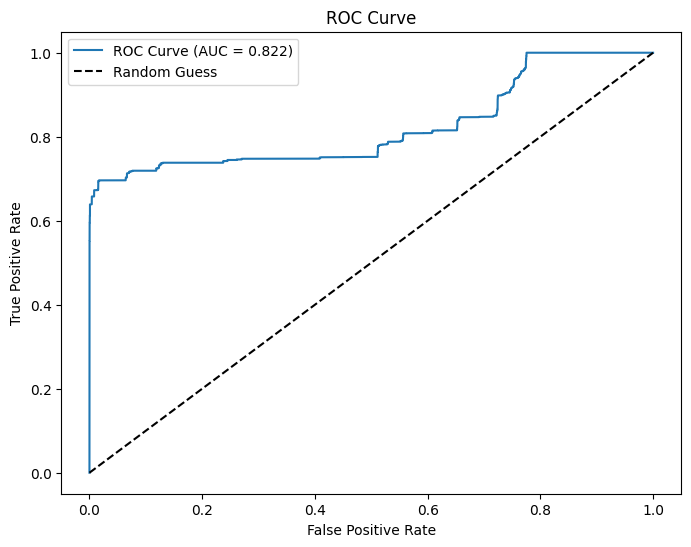


Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.99      0.90     12261
   Anomalous       0.97      0.67      0.79      7930

    accuracy                           0.86     20191
   macro avg       0.90      0.83      0.85     20191
weighted avg       0.88      0.86      0.86     20191



In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report
import seaborn as sns
import pandas as pd
import numpy as np

# Debug anomaly scores
print(f"Min anomaly score: {min(anomaly_scores):.6f}, Max anomaly score: {max(anomaly_scores):.6f}")
print(f"Number of positive scores: {sum(1 for s in anomaly_scores if s > 0)}")
for i, (score, label) in enumerate(zip(anomaly_scores[:10], true_labels[:10])):
    print(f"Sample {i}: Score = {score:.6f}, True Label = {label}")


# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Normal', 'Anomalous'], zero_division=0))



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


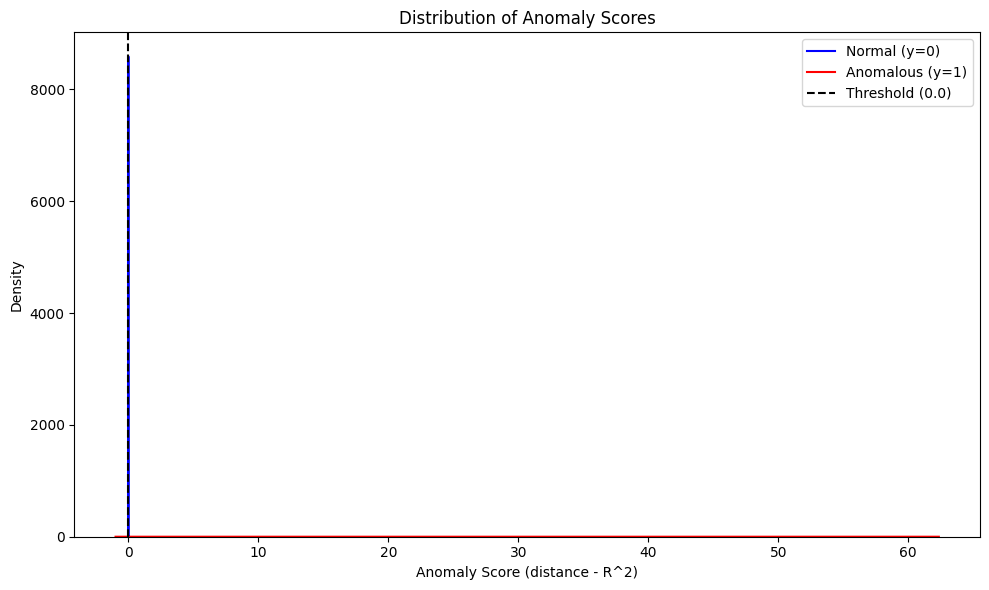

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
normal_scores = [s for s, y in zip(anomaly_scores, true_labels) if y == 0]
anomalous_scores = [s for s, y in zip(anomaly_scores, true_labels) if y == 1]

# KDE plots
sns.kdeplot(normal_scores, label='Normal (y=0)', color='blue')
sns.kdeplot(anomalous_scores, label='Anomalous (y=1)', color='red')

# Threshold
plt.axvline(x=0.0, color='black', linestyle='--', label='Threshold (0.0)')

plt.xlabel('Anomaly Score (distance - R^2)')

plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
print(f"# Normal scores: {len(normal_scores)} | min: {min(normal_scores):.4f}, max: {max(normal_scores):.4f}")
print(f"# Anomalous scores: {len(anomalous_scores)} | min: {min(anomalous_scores):.4f}, max: {max(anomalous_scores):.4f}")


# Normal scores: 12261 | min: -0.0002, max: 0.0151
# Anomalous scores: 7930 | min: -0.0002, max: 61.3685


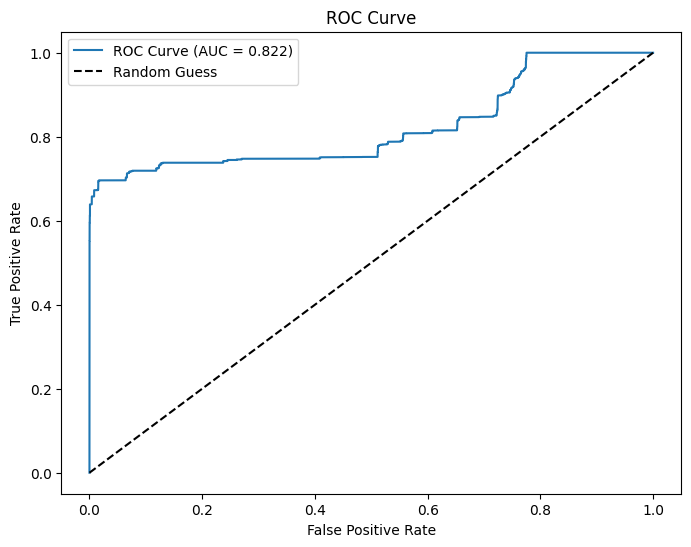

In [52]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

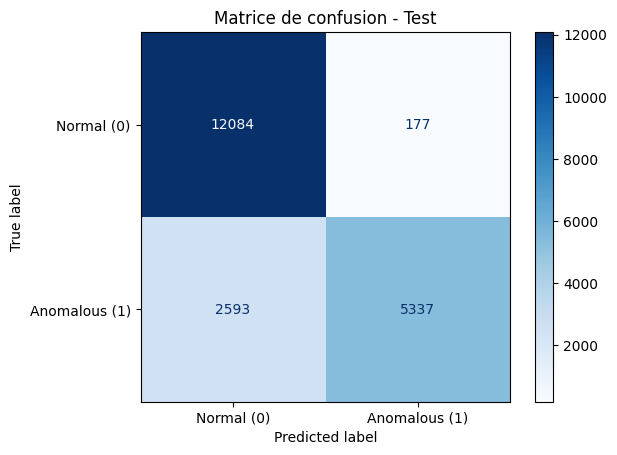

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Anomalous (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Test")
plt.grid(False)
plt.show()


In [54]:
# # Enregistrer le modèle GGNN
# torch.save(model.state_dict(), 'gGnn_model.pth')

# # Enregistrer les paramètres du centre c et du rayon R
# torch.save({
#     'center': criterion.c,
#     'radius': criterion.R
# }, 'deep_svdd_params.pth')


In [56]:
torch.save({
    'model_state_dict': model.state_dict(),
    'center': criterion.c,
    'radius': criterion.R,
}, 'ggnn_Deep_svdd.pth')


In [ ]:
# checkpoint = torch.load('ggnn_deep_svdd.pth')
# model = GGNN(num_node_features=306, hidden_channels=300, num_edge_types=3, num_iterations=2)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
# model.eval()

# criterion = DeepSVDDLoss(c=checkpoint['center'], mu=0.05, lambda_reg=0.001)
# criterion.R.data = checkpoint['radius']
